## **Imports**

In [1]:
#necessary imports 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from numpy import arange
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import f1_score

## **Reading the csv**

In [2]:
#importing the train and test files 
df_train = pd.read_csv("/content/sample_data/student_performance_train.csv", sep=',')
df_test = pd.read_csv("/content/sample_data/student_performance_test.csv", sep=',')

## **Preprocessing**

In [3]:
# converting scores to a 5-class categorical value
df=[df_train,df_test]
for x in df: 
    x['final_grade'] = 'na'
    x.loc[(x.G3 >= 16) & (x.G3 <= 20), 'final_grade'] = 'excellent' 
    x.loc[(x.G3 >= 14) & (x.G3 <= 15), 'final_grade'] = 'good' 
    x.loc[(x.G3 >= 12) & (x.G3 <= 13), 'final_grade'] = 'satisfactory' 
    x.loc[(x.G3 >= 10) & (x.G3 <= 11), 'final_grade'] = 'sufficient' 
    x.loc[(x.G3 >= 0) & (x.G3 <= 9), 'final_grade'] = 'fail' 
    x.drop(['G3'], axis = 1,inplace=True)

    x['period1_grade'] = 'na'
    x.loc[(x.G1 >= 16) & (x.G1 <= 20), 'period1_grade'] = 'excellent' 
    x.loc[(x.G1 >= 14) & (x.G1 <= 15), 'period1_grade'] = 'good' 
    x.loc[(x.G1 >= 12) & (x.G1 <= 13), 'period1_grade'] = 'satisfactory' 
    x.loc[(x.G1 >= 10) & (x.G1 <= 11), 'period1_grade'] = 'sufficient' 
    x.loc[(x.G1 >= 0) & (x.G1 <= 9), 'period1_grade'] = 'fail' 

    x['period2_grade'] = 'na'
    x.loc[(x.G2 >= 16) & (x.G2 <= 20), 'period2_grade'] = 'excellent' 
    x.loc[(x.G2 >= 14) & (x.G2 <= 15), 'period2_grade'] = 'good' 
    x.loc[(x.G2 >= 12) & (x.G2 <= 13), 'period2_grade'] = 'satisfactory' 
    x.loc[(x.G2 >= 10) & (x.G2 <= 11), 'period2_grade'] = 'sufficient' 
    x.loc[(x.G2 >= 0) & (x.G2 <= 9), 'period2_grade'] = 'fail' 

In [4]:
#converting categorical data to numeric  
cols=['school','sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet',
      'romantic']
df=[df_train,df_test]
for x in df: 
    for col in cols:
        le = preprocessing.LabelEncoder()
        x[col] = le.fit_transform(x[col])
    x['Mjob'] = x['Mjob'].map({'teacher': 1, 'health': 2, 'services': 3, 'at_home': 4, 'other': 5})
    x['Fjob'] = x['Fjob'].map({'teacher': 1, 'health': 2, 'services': 3, 'at_home': 4, 'other': 5})
    x['reason'] = x['reason'].map({'home': 1, 'reputation': 2, 'course': 3, 'other': 4})
    x['guardian'] = x['guardian'].map({'mother': 1, 'father': 2, 'other': 3})

In [5]:
#mapping the scores based on the given rules 
df=[df_train,df_test]
for x in df:
    x['final_grade'] = x['final_grade'].map({'excellent': 4, 'good': 3, 'satisfactory': 2, 'sufficient': 1, 'fail':0})
    x['period1_grade'] = x['period1_grade'].map({'excellent': 4, 'good': 3, 'satisfactory': 2, 'sufficient': 1, 'fail':0})
    x['period2_grade'] = x['period2_grade'].map({'excellent': 4, 'good': 3, 'satisfactory': 2, 'sufficient': 1, 'fail':0})

In [6]:
#confusion matrix 
def conf_mat(y,y_pred):
    cm=confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## **Trivial system and Baseline System**

**1. Predicting first period academic performance without available academic performance** 

In [7]:
def trivial_system(X_train,y_train): 
    #grouping data into classes 
    Xy0 = y_train.value_counts()[0]
    Xy1 = y_train.value_counts()[1]
    Xy2 = y_train.value_counts()[2]
    Xy3 = y_train.value_counts()[3]
    Xy4 = y_train.value_counts()[4]

    #calculating prior probability 
    prior0 = Xy0 / len(X_train)
    prior1 = Xy1 / len(X_train)
    prior2 = Xy2 / len(X_train)
    prior3 = Xy3 / len(X_train)
    prior4 = Xy4 / len(X_train)

    # #running the trivial system at least 10 times
    y=[]
    for i in range(10):
        x=[]
        for j in range(len(X_test)):
            rand=random.choices([0,1,2,3,4], weights=(prior0,prior1,prior2,prior3,prior4), k=1)
            x.append(rand[0])
        y.append(x)

    #taking the average of the results 
    y_train_avg=[]
    y_sum=np.sum(y, axis=0)
    y_pred=y_sum/10
    for i in range(len(y_pred)):
        y_train_avg.append(round(y_pred[i]))
    print("Test accuracy",accuracy_score(y_test, y_train_avg)*100)
    print("Macro F1 score",f1_score(y_test, y_train_avg, average='macro'))
    conf_mat(y_test, y_train_avg)

In [8]:
def baseline_system(X_train,y_train):
    #fitting the model on train data
    model = NearestCentroid()
    results = model.fit(X_train, y_train)
    print("Train accuracy",model.score(X_train, y_train))
    #making predictions on test 
    pred=results.predict(X_test)
    print("Test accuracy",accuracy_score(y_test, pred))
    print("Macro F1 score",f1_score(y_test, pred, average='macro'))
    conf_mat(y_test, pred)

In [9]:
#preparing data for mission one 
train=df_train.copy()
test=df_test.copy()

X_train = train.drop(['G1','G2','final_grade', 'period1_grade', 'period2_grade', 'guardian','reason','Mjob','Fjob'], axis = 1)
y_train = train['period1_grade']

X_test = test.drop(['G1','G2','final_grade', 'period1_grade', 'period2_grade', 'guardian','reason','Mjob','Fjob'], axis = 1)
y_test = test['period1_grade']

Test accuracy 23.31288343558282
Macro F1 score 0.12268774703557313


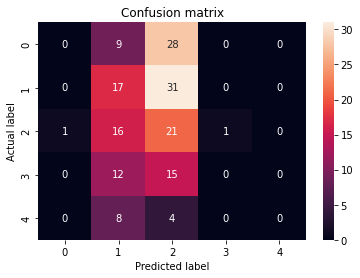

In [10]:
trivial_system(X_train,y_train)

Train accuracy 0.24074074074074073
Test accuracy 0.26380368098159507
Macro F1 score 0.2542378060975512


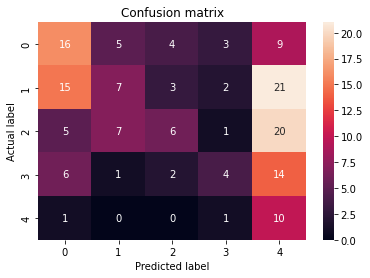

In [11]:
baseline_system(X_train,y_train)

**2. Predicting final academic performance without prior academic performance**

In [12]:
#preparing data for mission two 
train=df_train.copy()
test=df_test.copy()

X_train = train.drop(['G1','G2','final_grade', 'period1_grade','period2_grade', 'guardian','reason','Mjob','Fjob'], axis = 1)
y_train = train['final_grade']

X_test = test.drop(['G1','G2','final_grade', 'period1_grade', 'period2_grade','guardian','reason','Mjob','Fjob'], axis = 1)
y_test = test['final_grade']

Test accuracy 23.31288343558282
Macro F1 score 0.11550737729599518


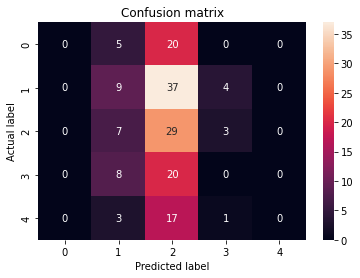

In [13]:
trivial_system(X_train,y_train)

Train accuracy 0.2962962962962963
Test accuracy 0.26380368098159507
Macro F1 score 0.2567999749410724


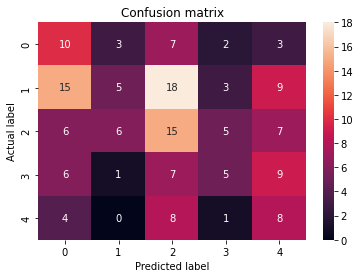

In [14]:
baseline_system(X_train,y_train)

**3. Predicting final academic performance using all available prior academic performance**

In [15]:
#preparing data for mission three
train=df_train.copy()
test=df_test.copy()

X_train = train.drop(['final_grade', 'period1_grade','guardian','period2_grade', 'reason','Mjob','Fjob'], axis = 1)
y_train = train['final_grade']

X_test = test.drop(['final_grade', 'period1_grade','guardian', 'period2_grade', 'reason','Mjob','Fjob'], axis = 1)
y_test = test['final_grade']

Test accuracy 27.607361963190186
Macro F1 score 0.1571910473334761


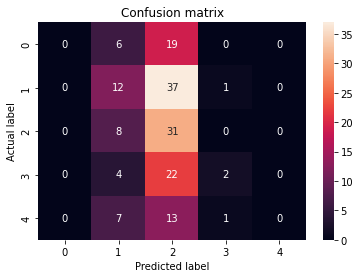

In [16]:
trivial_system(X_train,y_train)

Train accuracy 0.676954732510288
Test accuracy 0.6012269938650306
Macro F1 score 0.6150584274113686


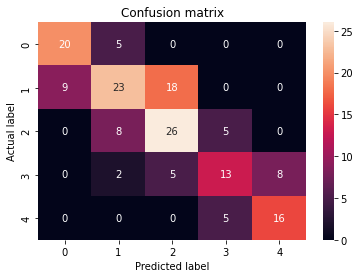

In [17]:
baseline_system(X_train,y_train)

## **Feature engineering**

In [18]:
df=[df_train,df_test]
for x in df: 
    #adding new columns 
    x['same'] = 0
    x.loc[(x.period1_grade >= 3) & (x.period2_grade>=3), 'same'] = 1
    x['average'] = x[['G1', 'G2']].mean(axis=1)
    x.drop(['period2_grade'], axis = 1,inplace=True)
    x['M_edu'] = 0
    x.loc[(x['Medu']>=3), 'M_edu'] = 1
    x['F_edu'] = 0
    x.loc[(x['Fedu']>=3), 'F_edu'] = 1
    x['MF_same'] = 0
    x.loc[(x.M_edu == 1) & (x.F_edu ==1), 'MF_same'] = 1 
    x['fail']=0
    #new column failure 
    x.loc[(x.failures <= 3), 'fail'] = 0 
    x.loc[(x.failures == 0), 'fail'] = 1
    x['avg'] = 'na'
    #converting average score to categories 
    x.loc[(x.average > 15) & (x.average <= 20), 'avg'] = 4
    x.loc[(x.average > 13) & (x.average <= 15), 'avg'] = 3
    x.loc[(x.average > 11) & (x.average <= 13), 'avg'] = 2
    x.loc[(x.average > 9) & (x.average <= 11), 'avg'] = 1
    x.loc[(x.average > 0) & (x.average <= 9), 'avg'] = 0

Text(0, 0.5, 'Number of Student')

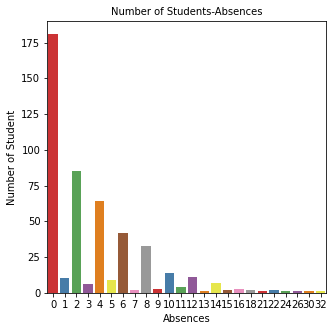

In [19]:
#plotting absences 
plt.figure(figsize=(5,5))
sns.countplot(df_train.absences, palette='Set1')
plt.title('Number of Students-Absences',fontsize=10)
plt.xlabel('Absences', fontsize=10)
plt.ylabel('Number of Student', fontsize=10)

In [20]:
#converting absences to categories 
df=[df_train,df_test]
for x in df: 
    x['absence'] = 'na'
    x.loc[(x.absences >= 15) & (x.absences <= 32), 'absence'] = 0
    x.loc[(x.absences >= 11) & (x.absences <= 14), 'absence'] = 1
    x.loc[(x.absences >= 5) & (x.absences <= 10), 'absence'] = 2
    x.loc[(x.absences >= 0) & (x.absences <= 4), 'absence'] = 3
    x.drop(['absences'], axis = 1,inplace=True)

Text(0, 0.5, 'Number of Student')

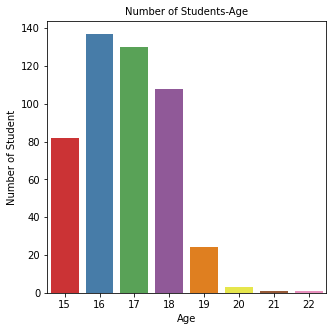

In [21]:
#plotting age 
plt.figure(figsize=(5,5))
sns.countplot(df_train.age, palette='Set1')
plt.title('Number of Students-Age',fontsize=10)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Number of Student', fontsize=10)

In [22]:
#converting age to categories 
df=[df_train,df_test]
for x in df: 
    x['age_'] = 'na'
    x.loc[(x.age >= 15) , 'age_'] = 3
    x.loc[(x.age >= 16) & (x.age <= 17), 'age_'] = 2
    x.loc[(x.age >= 19) & (x.age <= 18), 'age_'] = 1
    x.loc[(x.age >= 20) & (x.age <= 22), 'age_'] = 0 
    x.drop(['age'], axis = 1,inplace=True)

Text(0, 0.5, 'Number of Student')

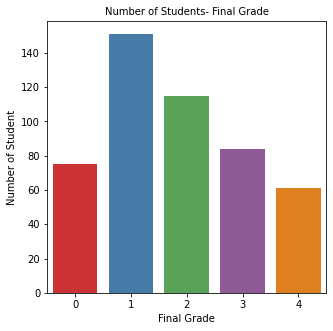

In [23]:
#checking for class imbalance in the final grade 
plt.figure(figsize=(5,5))
sns.countplot(df_train.final_grade, order=[0,1,2,3,4], palette='Set1')
plt.title('Number of Students- Final Grade',fontsize=10)
plt.xlabel('Final Grade', fontsize=10)
plt.ylabel('Number of Student', fontsize=10)

Text(0, 0.5, 'Number of Student')

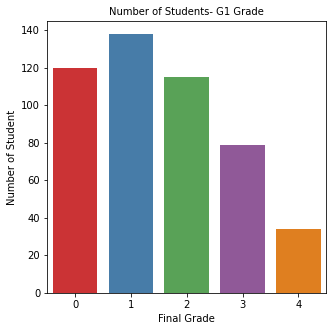

In [24]:
#checking for class imbalance in the G1 grade 
plt.figure(figsize=(5,5))
sns.countplot(df_train.period1_grade,  order=[0,1,2,3,4],palette='Set1')
plt.title('Number of Students- G1 Grade',fontsize=10)
plt.xlabel('Final Grade', fontsize=10)
plt.ylabel('Number of Student', fontsize=10)

In [25]:
#handling class imbalance - mission 1
smote = SMOTE()
train=df_train.copy()
test=df_test.copy()

X_train_1 = train.drop(['G1','G2','final_grade', 'period1_grade','average','same','avg'], axis = 1)
y_train_1 = train['period1_grade']
# X_train_1, y_train_1 = SMOTE(k_neighbors=1).fit_resample(X, y)
# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_train_1))
# X_test_1 = test.drop(['G1','G2','final_grade','period1_grade'], axis = 1)

X_test_1 = test.drop(['G1','G2','final_grade','period1_grade','average','same','avg'], axis = 1)
y_test_1 = test['period1_grade']

In [26]:
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((486, 34), (163, 34), (486,), (163,))

In [27]:
#handling class imbalance - mission 2 
smote = SMOTE()
train=df_train.copy()
test=df_test.copy()
# X_train_2 = train.drop(['G1','G2','final_grade', 'period1_grade'], axis = 1)

X_train_2 = train.drop(['G1','G2','final_grade', 'period1_grade','average','same','avg'], axis = 1)
y_train_2 = train['final_grade']
# X_train_2, y_train_2 = smote.fit_resample(X, y)
# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_train_2))
# X_test_2 = test.drop(['G1','G2','final_grade','period1_grade'], axis = 1)

X_test_2 = test.drop(['G1','G2','final_grade','period1_grade','average','same','avg'], axis = 1)
y_test_2 = test['final_grade']

In [28]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((486, 34), (163, 34), (486,), (163,))

In [29]:
#handling class imbalance - mission 3
smote = SMOTE()
train=df_train.copy()
test=df_test.copy()

X_train_3 = train.drop(['final_grade', 'period1_grade'], axis = 1)
y_train_3 = train['final_grade']
# X_train_3, y_train_3 = smote.fit_resample(X, y)
# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_train_3))

X_test_3 = test.drop(['final_grade','period1_grade'], axis = 1)
y_test_3 = test['final_grade']

In [30]:
X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape

((486, 39), (163, 39), (486,), (163,))

### **Chi square and ANOVA test**

**1. For mission 1** 

In [31]:
#chi2 test 
f_score =chi2(X_train_1, y_train_1)
pvalue = pd.Series(f_score[1])
pvalue.index=X_train_1.columns 
pvalue.sort_values(ascending=True)

failures      2.213868e-31
school        5.685634e-07
Medu          3.190681e-04
fail          3.139951e-03
Walc          3.413567e-03
Fedu          3.593467e-03
MF_same       4.519480e-03
M_edu         6.526057e-03
Dalc          6.954130e-03
F_edu         1.425523e-02
studytime     1.820541e-02
higher        2.327501e-02
Mjob          7.969911e-02
schoolsup     1.987602e-01
traveltime    2.230731e-01
internet      3.009678e-01
activities    3.098364e-01
sex           3.430792e-01
health        3.554174e-01
paid          3.634191e-01
address       3.885038e-01
reason        4.178006e-01
Fjob          4.578139e-01
freetime      5.520369e-01
famsup        6.589538e-01
absence       7.960418e-01
famrel        8.022579e-01
goout         8.435803e-01
romantic      8.766715e-01
famsize       8.879097e-01
guardian      9.237833e-01
nursery       9.306066e-01
Pstatus       9.951690e-01
age_          9.991033e-01
dtype: float64

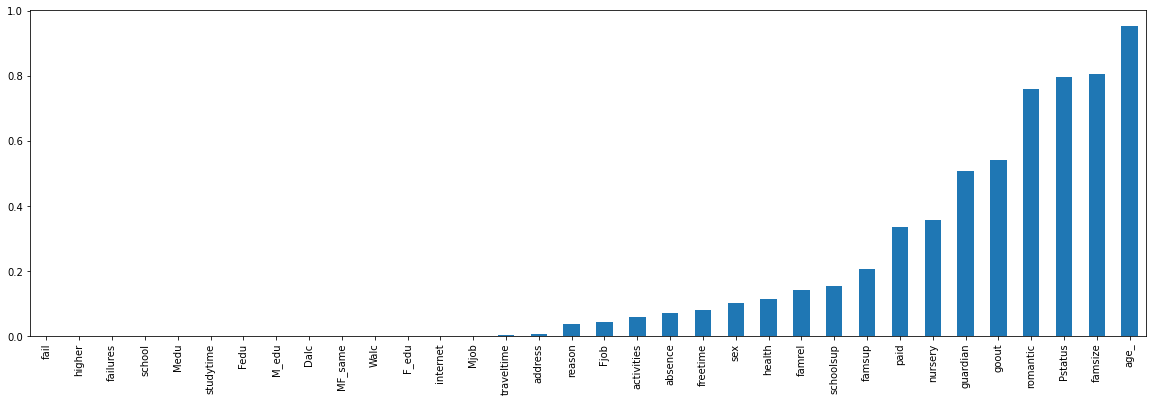

In [32]:
#ANOVA test 
univariate=f_classif(X_train_1, y_train_1)
univariate = pd.Series(univariate[1])
univariate.index=X_train_1.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20,6))

In [33]:
#dropping the least correlated features 
X_train_1 = X_train_1.drop(['Pstatus','age_','famsize','romantic','nursery','guardian'], axis = 1)
X_test_1 = X_test_1.drop(['Pstatus','age_','famsize','romantic','nursery','guardian'], axis = 1)

**2. For mission 2** 

In [34]:
#chi2 test 
f_score =chi2(X_train_2, y_train_2)
pvalue = pd.Series(f_score[1])
pvalue.index=X_train_2.columns 
pvalue.sort_values(ascending=True)

failures      6.384143e-33
school        8.733192e-06
Medu          4.613748e-05
Fedu          5.347965e-04
MF_same       6.081634e-04
F_edu         1.916374e-03
Walc          2.393238e-03
fail          2.500457e-03
M_edu         3.636308e-03
Dalc          4.722865e-03
schoolsup     1.341650e-02
studytime     2.469317e-02
higher        4.377977e-02
Mjob          6.891810e-02
traveltime    1.441364e-01
paid          1.502227e-01
sex           1.674193e-01
goout         2.770860e-01
Fjob          2.834340e-01
freetime      2.981731e-01
internet      2.995122e-01
health        3.200035e-01
reason        3.796750e-01
activities    4.320329e-01
address       4.765570e-01
famsize       5.115882e-01
romantic      5.627739e-01
absence       6.930995e-01
famsup        8.057053e-01
nursery       8.422840e-01
famrel        8.530165e-01
guardian      9.466250e-01
age_          9.899682e-01
Pstatus       9.979086e-01
dtype: float64

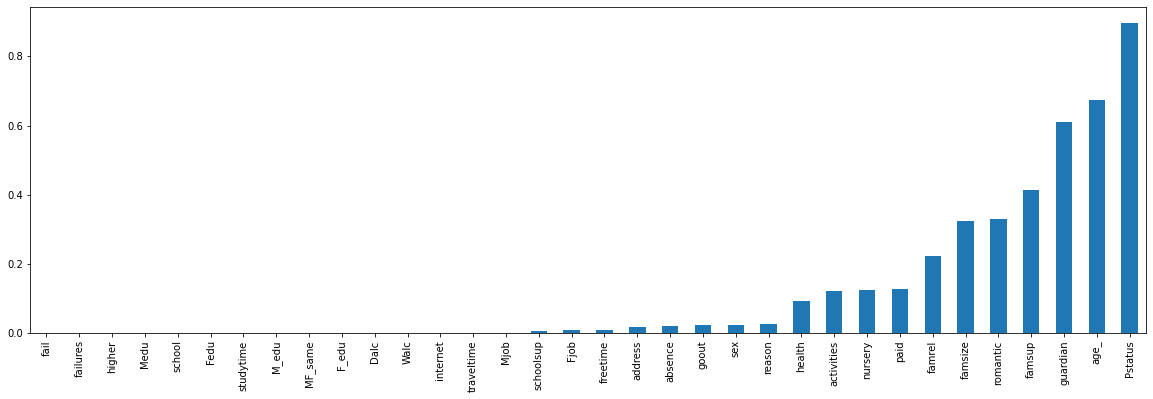

In [35]:
#ANOVA test 
univariate=f_classif(X_train_2, y_train_2)
univariate = pd.Series(univariate[1])
univariate.index=X_train_2.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20,6))

In [36]:
#dropping the least correlated features 
X_train_2 = X_train_2.drop(['Pstatus','age_','famsup','nursery','famrel','guardian'], axis = 1)
X_test_2 = X_test_2.drop(['Pstatus','age_','famsup','nursery','famrel','guardian'], axis = 1)

**3. For mission 3** 

In [37]:
#chi2 test 
f_score =chi2(X_train_3, y_train_3)
pvalue = pd.Series(f_score[1])
pvalue.index=X_train_3.columns 
pvalue.sort_values(ascending=True)

avg           1.596098e-74
G2            2.227805e-57
same          2.633244e-57
average       5.816258e-53
G1            1.016932e-48
failures      6.384143e-33
school        8.733192e-06
Medu          4.613748e-05
Fedu          5.347965e-04
MF_same       6.081634e-04
F_edu         1.916374e-03
Walc          2.393238e-03
fail          2.500457e-03
M_edu         3.636308e-03
Dalc          4.722865e-03
schoolsup     1.341650e-02
studytime     2.469317e-02
higher        4.377977e-02
Mjob          6.891810e-02
traveltime    1.441364e-01
paid          1.502227e-01
sex           1.674193e-01
goout         2.770860e-01
Fjob          2.834340e-01
freetime      2.981731e-01
internet      2.995122e-01
health        3.200035e-01
reason        3.796750e-01
activities    4.320329e-01
address       4.765570e-01
famsize       5.115882e-01
romantic      5.627739e-01
absence       6.930995e-01
famsup        8.057053e-01
nursery       8.422840e-01
famrel        8.530165e-01
guardian      9.466250e-01
a

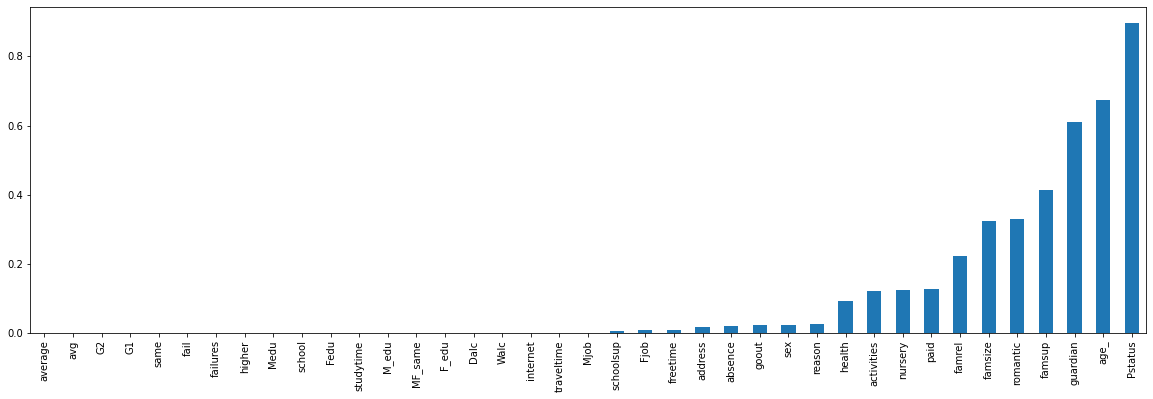

In [38]:
#ANOVA test 
univariate=f_classif(X_train_3, y_train_3)
univariate = pd.Series(univariate[1])
univariate.index=X_train_3.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20,6))

In [39]:
#dropping the least correlated features 
X_train_3 = X_train_3.drop(['Pstatus','age_','famrel','famsup','guardian','nursery'], axis = 1)
X_test_3 = X_test_3.drop(['Pstatus','famrel','age_','famsup','guardian','nursery'], axis = 1)

## **Adding dummies for categorical attributes** 

In [40]:
#adding dummies for the nominal values 
X_train_1=pd.get_dummies(X_train_1, columns = ['reason','Fjob','Mjob'])
X_test_1=pd.get_dummies(X_test_1, columns = ['reason','Fjob','Mjob'])

X_train_2=pd.get_dummies(X_train_2, columns = ['reason','Fjob','Mjob'])
X_test_2=pd.get_dummies(X_test_2, columns = ['reason','Fjob','Mjob'])

X_train_3=pd.get_dummies(X_train_3, columns = ['reason','Fjob','Mjob'])
X_test_3=pd.get_dummies(X_test_3, columns = ['reason','Fjob','Mjob'])

##**Principal Component Analysis** 

In [41]:
# pca = PCA(n_components=20)
# X_train_1 = pca.fit_transform(X_train_1)
# # print(pca.explained_variance_ratio_.sum())
# X_test_1= pca.transform(X_test_1)

# pca = PCA(n_components=25)
# X_train_2 = pca.fit_transform(X_train_2)
# # print(pca.explained_variance_ratio_.sum())
# X_test_2= pca.transform(X_test_2)

# pca = PCA(n_components=27)
# X_train_3 = pca.fit_transform(X_train_3)
# print(pca.explained_variance_ratio_.sum())
# X_test_3 = pca.transform(X_test_3)

## **K Nearest Neighbours**

In [42]:
def KNN(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()
    neighbors=list(range(1,10,1))
    leaf= 2 ** np.arange(10)
    #list of hyperparameters 
    param_grid = { 'n_neighbors':neighbors, 
                'leaf_size': leaf,
                'p': (1,2),
                'algorithm':('auto', 'kd_tree','brute','ball_tree'),
                'weights': ('uniform', 'distance'),
                'metric': ("minkowski","euclidean", "manhattan", "chebyshev")}
    #grid search 
    grid = GridSearchCV(knn, param_grid, cv=5, n_jobs = -1, scoring='accuracy')  
    #model fit 
    grid_search=grid.fit(X_train, y_train)
    print(grid_search.best_params_)
    accuracy = grid_search.best_score_ *100
    print(" Train accuracy {:.2f}%".format(accuracy))
    #prediction 
    pred=grid_search.predict(X_test)
    #performance metrics 
    print("Test accuracy:",(accuracy_score(y_test, pred)))
    print("Macro F1 score",f1_score(y_test, pred, average='macro'))
    conf_mat(y_test, pred)

**1. Predicting first period academic performance without available academic performance** 

{'algorithm': 'kd_tree', 'leaf_size': 256, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
 Train accuracy 34.57%
Test accuracy: 0.3558282208588957
Macro F1 score 0.2976345682066506


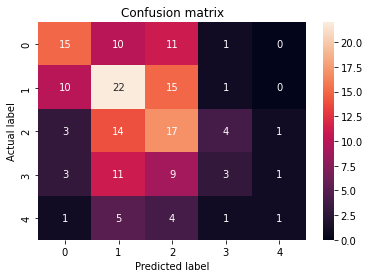

In [43]:
KNN(X_train_1, y_train_1, X_test_1, y_test_1)

**2. Predicting final academic performance without prior academic performance** 

{'algorithm': 'ball_tree', 'leaf_size': 128, 'metric': 'minkowski', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
 Train accuracy 36.01%
Test accuracy: 0.32515337423312884
Macro F1 score 0.3038001243198606


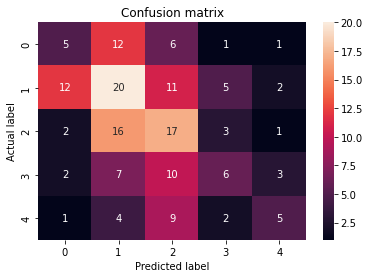

In [44]:
KNN(X_train_2, y_train_2, X_test_2, y_test_2)

**3. Predicting final academic performance using all available prior academic performance** 

{'algorithm': 'kd_tree', 'leaf_size': 64, 'metric': 'minkowski', 'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
 Train accuracy 70.77%
Test accuracy: 0.7484662576687117
Macro F1 score 0.7467938457905883


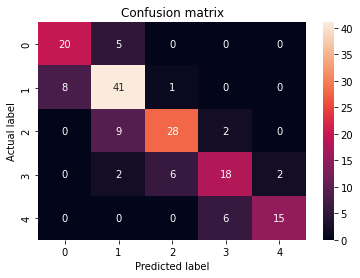

In [45]:
KNN(X_train_3, y_train_3, X_test_3, y_test_3)

## **Support Vector Machine for Classification**

In [46]:
def support_vector(X_train, y_train, X_test, y_test):
    #list of hyperparameters 
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf','poly']}
    #grivd search 
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    accuracy = grid.best_score_ *100
    print(" Train accuracy {:.2f}%".format(accuracy))

    #getting predictions 
    grid_predictions = grid.predict(X_test)
    
    # print performance 
    print("Test accuracy",accuracy_score(y_test, grid_predictions))
    print("Macro F1 score",f1_score(y_test, grid_predictions, average='macro'))
    conf_mat(y_test, grid_predictions)

**1. Predicting first period academic performance without available academic performance** 

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
 Train accuracy 37.44%
Test accuracy 0.4049079754601227
Macro F1 score 0.2848060606060606


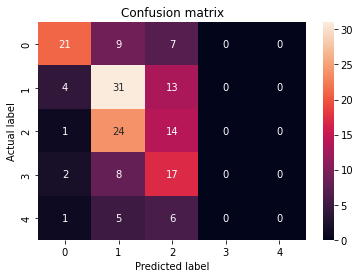

In [47]:
support_vector(X_train_1, y_train_1, X_test_1, y_test_1)

**2. Predicting final academic performance without prior academic performance** 

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
 Train accuracy 36.83%
Test accuracy 0.3619631901840491
Macro F1 score 0.33626055803803623


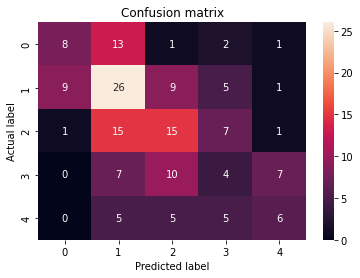

In [48]:
support_vector(X_train_2, y_train_2, X_test_2, y_test_2)

**3. Predicting final academic performance using all available prior academic performance** 

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
 Train accuracy 72.01%
Test accuracy 0.7607361963190185
Macro F1 score 0.754150550454394


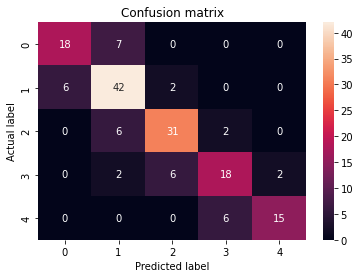

In [49]:
support_vector(X_train_3, y_train_3, X_test_3, y_test_3)

## **Artifical Neural Network**

In [50]:
def ANN(X_train, y_train, X_test, y_test, dim): 
    classifier = Sequential()
    #hidden layers
    classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', input_dim = dim))
    classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
    #dropout layer
    classifier.add(Dropout(0.2))
    #output layer 
    classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    #converting x and.y to suitable formats 
    X_train = np.asarray(X_train).astype(np.float32)
    y_train = pd.get_dummies(y_train, columns = ['final_grade'])
    y_train = np.asarray(y_train).astype(np.float32)

    X_test = np.asarray(X_test).astype(np.float32)
    y_test = pd.get_dummies(y_test, columns = ['final_grade'])
    y_test = np.asarray(y_test).astype(np.float32)

    #model fit 
    classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)
    score, acc = classifier.evaluate(X_train, y_train,batch_size=10)

    print('Train accuracy:', acc)

    #prediction 
    y_pred = classifier.predict(X_test)
    score, acc = classifier.evaluate(X_test, y_test,batch_size=10)

    #performance metrics 
    print('Test accuracy:', acc)
    y_test=np.argmax(y_test, axis=1)
    y_pred=np.argmax(y_pred, axis=1)
    print("Macro F1 score",f1_score(y_test, y_pred, average='macro'))
    conf_mat(y_test, y_pred)

**1. Predicting first period academic performance without available academic performance**

49/49 [==============================] - 0s 2ms/step - loss: 0.4153 - accuracy: 0.4177
Train accuracy: 0.41769546270370483
17/17 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.3926
Test accuracy: 0.39263802766799927
Macro F1 score 0.2722690053376383


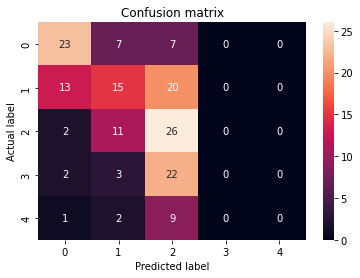

In [51]:
ANN(X_train_1, y_train_1, X_test_1, y_test_1, 39)

**2. Predicting final academic performance without prior academic performance** 

49/49 [==============================] - 0s 2ms/step - loss: 0.4426 - accuracy: 0.3930
Train accuracy: 0.3930041193962097
17/17 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.3129
Test accuracy: 0.3128834366798401
Macro F1 score 0.15952441183910954


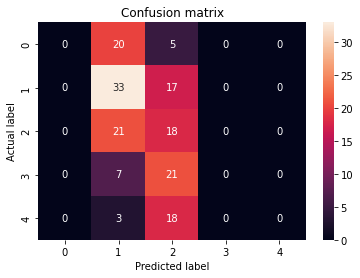

In [52]:
ANN(X_train_2, y_train_2, X_test_2, y_test_2, 39)

**3. Predicting final academic performance using all available prior academic performance**

49/49 [==============================] - 0s 2ms/step - loss: 0.2853 - accuracy: 0.7202
Train accuracy: 0.7201645970344543
17/17 [==============================] - 0s 2ms/step - loss: 0.2929 - accuracy: 0.7117
Test accuracy: 0.7116564512252808
Macro F1 score 0.661731772258088


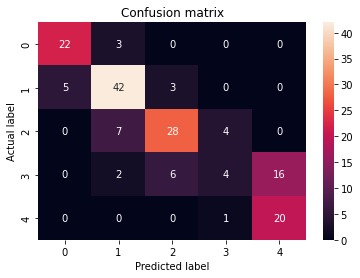

In [53]:
ANN(X_train_3, y_train_3, X_test_3, y_test_3, 44)